In [8]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [9]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [10]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split =0.2
)
test_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1156 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [12]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Freeze layers
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_407         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_3                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20
 4/50 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - AUC: 0.6099 - Precision: 0.5619 - Recall: 0.7437 - accuracy: 0.5521 - loss: 0.6987

W0000 00:00:1715156115.542849     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - AUC: 0.6260 - Precision: 0.6032 - Recall: 0.6309 - accuracy: 0.5868 - loss: 0.7128

W0000 00:00:1715156131.490328     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 468ms/step - AUC: 0.6264 - Precision: 0.6035 - Recall: 0.6303 - accuracy: 0.5869 - loss: 0.7123 - val_AUC: 0.3868 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7467
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - AUC: 0.5194 - Precision: 0.4793 - Recall: 0.5758 - accuracy: 0.4987 - loss: 0.7307
Epoch 2: val_accuracy improved from 0.50000 to 0.59028, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - AUC: 0.5202 - Precision: 0.4803 - Recall: 0.5769 - accuracy: 0.4998 - loss: 0.7306 - val_AUC: 0.7783 - val_Precision: 0.5542 - val_Recall: 0.9236 - val_accuracy: 0.5903 - val_loss: 0.6600
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - AUC: 0.6086 - Precision: 0.5169 - Recall: 0.6042 - accuracy: 0.5906 - loss: 0.6955
Epoch 3: val_accuracy improved from 0.59028 to 0.70139, saving model to best_model.keras

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy did not improve from 0.70139
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - AUC: 0.6633 - Precision: 0.4928 - Recall: 0.6026 - accuracy: 0.5951 - loss: 0.6856 - val_AUC: 0.7725 - val_Precision: 0.5962 - val_Recall: 0.8819 - val_accuracy: 0.6424 - val_loss: 0.6710
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - AUC: 0.6042 - Precision: 0.5831 - Recall: 0.6017 - accuracy: 0.6030 - loss: 0.7113
Epoch 7: val_accuracy did not improve from 0.70139
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - AUC: 0.6050 - Precision: 0.5850 - Recall: 0.6011 - accuracy: 0.6033 - loss: 0.7111 - val_AUC: 0.7738 - val_Precision: 0.5853 - val_Recall: 0.8819 - val_accuracy: 0.6285 - val_loss: 0.6708
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - AUC: 0.6712 - Precision: 0.7376 - Recall: 0.7254 - accuracy: 0.6645 - loss: 0.6421
Epoch 8: val_accuracy did not improve from 0.70139
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - AUC: 0.6710 - Precision: 0.7363 - Recall: 0.7250 - accuracy: 0.6637 -

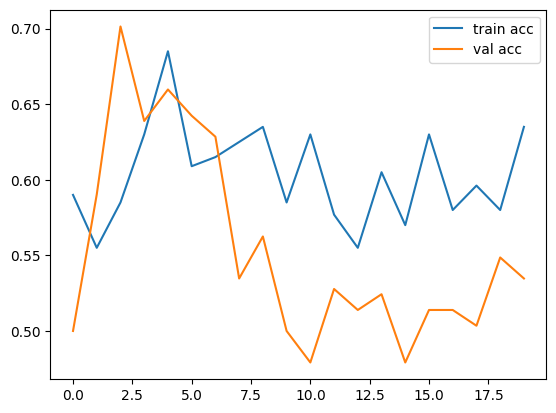

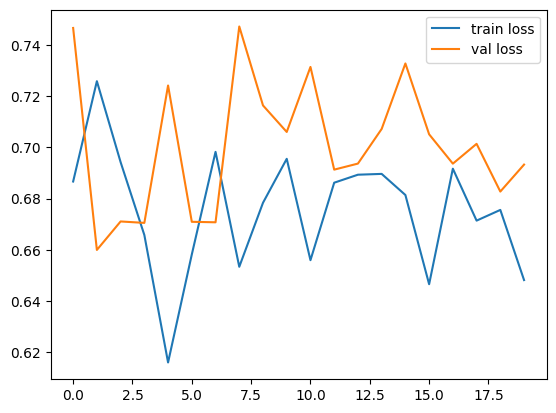

In [15]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('Inception_ResNet-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('Inception_ResNet-loss.png')
plt.show()

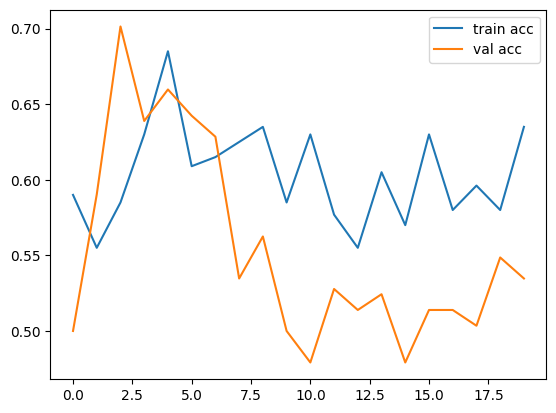

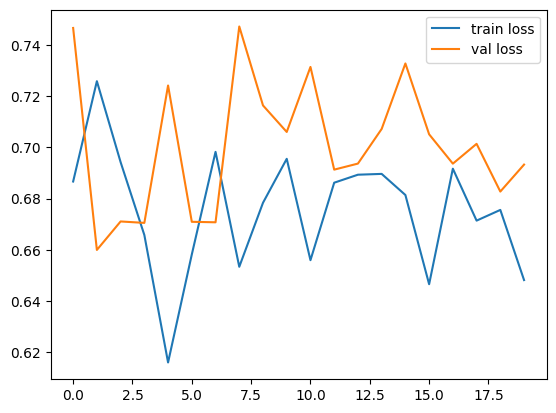

In [16]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('Inception_ResNet-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('Inception_ResNet-loss.png')
plt.show()

In [17]:
model.evaluate(test_generator)


106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - AUC: 0.8314 - Precision: 0.7061 - Recall: 0.9008 - accuracy: 0.7137 - loss: 0.5842


[0.581878662109375,
 0.85242760181427,
 0.7210031151771545,
 0.9126983880996704,
 0.7369668483734131]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
[[0.69237596]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Diabetic


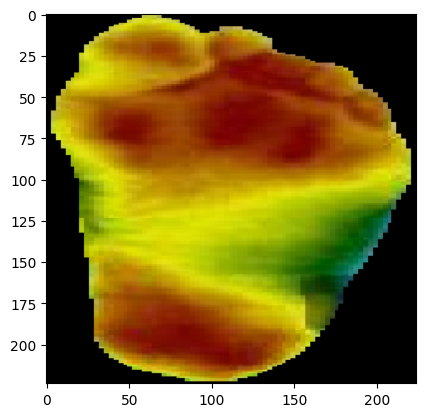

In [18]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[0.41771197]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Normal


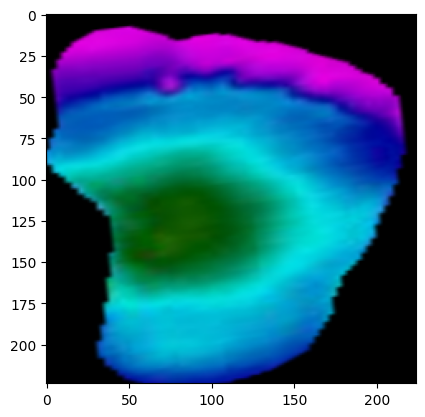

In [19]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase/val/Control Group/CG001_M_L-rotated1-rotated1.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))